In [1]:
using Images, PyPlot, PyCall, Docile
@pyimport matplotlib.cm as cm

INFO: Recompiling stale cache file /home/xentrics/.julia/lib/v0.5/Images.ji for module Images.
INFO: Recompiling stale cache file /home/xentrics/.julia/lib/v0.5/PyPlot.ji for module PyPlot.
INFO: Recompiling stale cache file /home/xentrics/.julia/lib/v0.5/Docile.ji for module Docile.
  likely near /home/xentrics/.julia/v0.5/Docile/src/Utilities.jl:122
 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in symbol(::SubString{String}, ::Vararg{SubString{String},N}) at ./deprecated.jl:30
 in collect(::Base.Generator{Array{SubString{String},1},Docile.Utilities.##2#4}) at ./array.jl:307
 in @H_str(::Any) at /home/xentrics/.julia/v0.5/Docile/src/Utilities.jl:17
 in include_from_node1(::String) at ./loading.jl:488 (repeats 3 times)
 in macro expansion; at ./none:2 [inlined]
 in anonymous at ./<missing>:?
 in eval(::Module, ::Any) at ./boot.jl:234
 in process_options(::Base.JLOptions) at ./client.jl:242
 in _start() at ./client.jl:321
while loading /home/xentrics/.julia/v0.5/Docile/src/Runn

In [2]:
function makeMask(r_out, r_in=0.0, AA=0.0; normalize=true)
    @assert(AA>=0.0, "Antialiasing border size cannot be negative!")
    mask = zeros(Float64, 2*r_out+1, 2*r_out+1)
    cen = (r_out+1, r_out+1)
    for x in -r_out:r_out
        for y in -r_out:r_out
            l = sqrt(x^2 + y^2)
            if r_in <= l < r_out + AA/2
                if l < r_out - AA/2
                    mask[x+cen[1], y+cen[2]] = 1.0
                else
                    mask[x+cen[1], y+cen[2]] = (r_out + AA/2 - l)/AA
                end
            end
        end
    end 
    
    return normalize ? mask/sum(mask) : mask
end

"""
    makeInnerMask(r_in[, AA=0.0])

Create a matrix filled with a ring of non-zero floats.
The sum of matrix is normalized to be equal to 1.0.

# Arguments
* `r_in::Int`: the inner radius of the ring. Must be smaller than r_out.
* `AA::Float64`: Thickness of antialiasing. 0.0 means no antialiasing.
"""
function makeInnerMask(r_in, AA=0.0; verbose=false)::Array{Float64,2}
    mask = makeMask(r_in, 0.0, AA)
    if verbose; plt[:figure](); plt[:axis]("off"); plt[:imshow](mask) end
    return mask
end

"""
    makeOuterMask(r_out, r_in[, AA=false])

Create a matrix filled with a ring of non-zero floats.
The sum of matrix is normalized to be equal to 1.0.

# Arguments
* `r_out::Int64`: the outer radius of the ring. Must be greater than r_in.
* `r_in::Int64`: the inner radius of the ring. Must be smaller than r_out.
* `AA`: Thickness of antialiasing. 0.0 means no antialiasing.

"""
function makeOuterMask(r_out, r_in, AA=0.0; verbose=false, subtract=false)::Array{Float64,2}
    if subtract
        mask = makeOuterMaskSubtracted(r_out, r_in, AA)
    else
        mask = makeMask(r_out, r_in, AA)
    end

    if verbose; plt[:figure](); plt[:axis]("off"); plt[:imshow](mask) end
    return mask
end

"""
In this version, the inner mask is subtracted. Using antialiasing, this will lead to an continuous transition from inner to outer.
For further information, see 'makeOuterMask'.
"""
function makeOuterMaskSubtracted(r_out, r_in, AA=0.0; verbose=false)::Array{Float64,2}
    mask = makeMask(r_out, 0.0, AA; normalize=false)
    
    # make the hole of the ring
    #mask_sub = zeros(Float64, 2*r_out+1, 2*r_out+1)
    mask_in = makeMask(r_in, 0.0, AA, normalize=false)
    println(size(mask_in))
    println(size(mask))
    println(size(mask[r_out-r_in+1:r_out+r_in+1, r_out-r_in+1:r_out+r_in+1]))
    flush(STDOUT)
    mask[r_out-r_in+1:r_out+r_in+1,r_out-r_in+1:r_out+r_in+1] -= mask_in
    
    #normalize mask, so that sum(mask) == 1.0
    mask /= sum(mask)
    
    if verbose; plt[:figure](); plt[:axis]("off"); plt[:imshow](mask) end
    return mask
end

makeOuterMaskSubtracted

In [3]:
function splat!(aa, ny, nx, ra; round=true)
	x = floor(Int64, rand()*nx)+1
	y = floor(Int64, rand()*ny)+1
	c = max(0.5, rand()) # val ∈ [0.5, 1.0]

    for dx in -ra:ra
        for dy in -ra:ra
            ix = x+dx
            iy = y+dy
            if 1<=ix<=nx && 1<=iy<=ny && (!round || round && sqrt(dx^2+dy^2) <= ra)
                aa[ix,iy] = c
            end
        end
    end
    
    return aa
end

"""
returns a grid initiated with splats
    
#Arguments
*`ny`: height
*`nx`: width
*`ra`: outer radius
"""
function initaa(ny, nx, ra)::Array{Float64,2}
	aa = zeros(Float64, ny,nx)
	for t in 0:((nx/ra)*(ny/ra))
		splat!(aa, ny, nx, ra)
	end
    return aa
end

initaa

In [4]:
#Hack: in the paper, λ is different for n and m! The smoothness allows us to use smaller masks for similar precision
function σ1(x::Float64, a::Float64)
    return 1.0 ./ (1.0 + exp(-4.0.*(x-a))) 
end

function σ2(x::Float64, a::Float64, b::Float64)
    return σ1(x,a).*(1.0 - σ1(x,b))
end

function σm(x::Float64, y::Float64, m::Float64)
    return x.*(1.0 - σ1(m, 0.5)) + y.*σ1(m, 0.5)
end

"""
Evaluate inner and outer filling of a cell. The used formulars and constants were proposed for smooth, stable gliders.
These can be found in the original smoothlife paper from 2011.

The function is a mapping of [0,1) x [0,1) ⟶ [0,1).

#Arguments
* `n::Float64`: outer filling ∈ [0,1]
* `m::Float64`: inner filling ∈ [0,1]
"""
function s(n::Float64, m::Float64)
    #Note: birth interval [b1,b2] and death interval [d1, d2]. Values based on original paper
    const b1 = 0.278
    const b2 = 0.365
    const d1 = 0.267
    const d2 = 0.445
    return σ2(n, σm(b1,d1,m), σm(b2,d2,m))
end

"""
smoothed integral step into the next generation.
    f(x, t + dt) = f(x) + dt * (2*s(n,m)-1) * f(x)

#Arguments
* `f::Float64`: value of the current cell (x,y) with f = f(x,y), n = mask_outer(x,y) , m = mask_inner(x,y)
* `n::Float64`: outer filling ∈ [0,1)
* `m::Float64`: inner filling ∈ [0,1)
* `dt::Float64`: distance in time
"""
function smoothStep(f::Float64, n::Float64, m::Float64, dt::Float64)
    #return f + dt*(2*s(n,m)-1)
    return f + dt*(2*snm(n,m)-1)
end

function smoothStep(f::Float64, n::Float64, m::Float64)
    return s(n,m)*f
end

# alternative solution
sigmoid_a(x, a, b) =  1 ./(1+exp(-4(x-a)/b))

sigmoid_b(x, b, eb) = 1 - sigmoid_a(x, b, eb)

sigmoid_ab(x, a, b, ea, eb) = sigmoid_a(x, a, ea) .* sigmoid_b(x, b, eb)

function sigmoid_mix(x, y, m, em)
    return x.*(1-sigmoid_a(m, 0.5, em)) + y.*sigmoid_a(m, 0.5, em)
end

function snm(n, m)
    const b1 = 0.278
    const b2 = 0.365
    const d1 = 0.267
    const d2 = 0.445
    const alphan = 0.028
    const alpham = 0.147
    return sigmoid_ab(n, sigmoid_mix(b1, d1, m, alpham), sigmoid_mix(b2, d2, m, alpham), alphan, alphan)
end


snm (generic function with 1 method)

In [5]:
function getGrid(width=100, height=100, random=true; r_out=21)::Tuple{Array{Float64,2}, Array{Float64,2}}
    if random
        #return (rand(width, height), Array{Float64,2}(width, height))
        return (initaa(height, width, r_out), Array{Float64, 2}(width, height))
    else
        return (zeros(Float64, width, height), Array{Float64,2}(width, height))
    end
end

getGrid (generic function with 4 methods)

(19,19)
(55,55)
(19,19)


 in depwarn(::

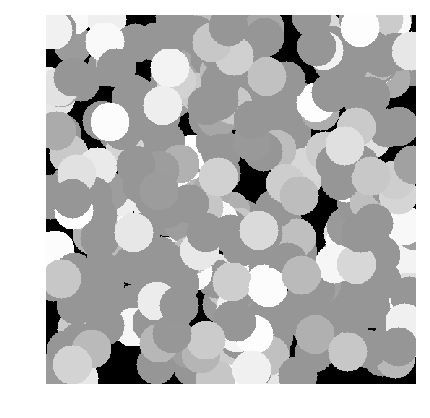

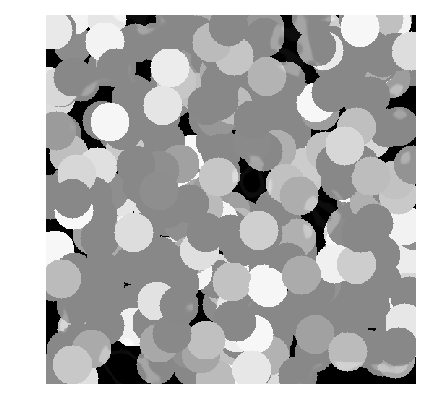

String, ::Symbol) at ./deprecated.jl:64
 in _kernelshift at /home/xentrics/.julia/v0.5/ImageFiltering/src/imfilter.jl:1049 [inlined]
 in kernelshift at /home/xentrics/.julia/v0.5/ImageFiltering/src/imfilter.jl:1046 [inlined]
 in factorstridedkernel(::Tuple{Base.OneTo{Int64},Base.OneTo{Int64}}, ::Array{Float64,2}) at /home/xentrics/.julia/v0.5/ImageFiltering/src/imfilter.jl:1036
 in factorkernel(::Array{Float64,2}) at /home/xentrics/.julia/v0.5/ImageFiltering/src/imfilter.jl:1024
 in imfilter at /home/xentrics/.julia/v0.5/ImageFiltering/src/imfilter.jl:10 [inlined]
 in imfilter at /home/xentrics/.julia/v0.5/ImageFiltering/src/imfilter.jl:5 [inlined]
 in imfilter(::Array{Float64,2}, ::Array{Float64,2}, ::String, ::ImageFiltering.Algorithm.FFT) at /home/xentrics/.julia/v0.5/ImageFiltering/src/deprecated.jl:49
 in imfilter_fft(::Array{Float64,2}, ::Array{Float64,2}, ::String, ::Int64) at /home/xentrics/.julia/v0.5/ImageFiltering/src/deprecated.jl:58
 in macro expansion; at ./In[6]:19 [inli

In [6]:
# initiation
showOnConsole=false
sleepTime=0.1
runs = 1
r_in = 9
r_out = 3*r_in
dt = 0.05
grid_width = 512
grid_height = 512
(curGrid, newGrid) = getGrid(grid_width, grid_height; r_out=r_out)
mask_in = makeInnerMask(r_in, 1.0; verbose=false)
mask_out = makeOuterMask(r_out, r_in, 1.0; verbose=false, subtract=true)

plt[:axis]("off")
im = plt[:imshow](curGrid, cmap=cm.Greys_r, vmin = 0.0, vmax = 1.0)

for run in 1:runs
    # step
    convInner = imfilter_fft(curGrid, mask_in, "circular")
    convOuter = imfilter_fft(curGrid, mask_out, "circular") # fft is faster for masks greater 20x20
    #plt[:figure](); plt[:axis]("off"); plt[:imshow](convInner, cmap=cm.Greys_r)
    #plt[:figure](); plt[:axis]("off"); plt[:imshow](convOuter, cmap=cm.Greys_r)
    for x in 1:grid_width
        for y in 1:grid_height
            newGrid[x,y] = smoothStep(curGrid[x,y], convOuter[x,y], convInner[x,y], dt)
        end
    end

    # swap
    curGrid = newGrid
    newGrid = zeros(Float64, grid_width, grid_height)

    if showOnConsole
        im[:set_data](curGrid)
        plt[:draw]()
        sleep(sleepTime)
    else
        plt[:figure](); plt[:axis]("off"); plt[:imshow](curGrid, cmap=cm.Greys_r, vmin = 0.0, vmax = 1.0)
    end
end

In [7]:
"""
Start the smoothlife simulation. All results are estimates. Smaller time steps and greater masks improve resolution
but increase computation time also.

#Arguments
* `iterations` : The number of total convolutions
* `step_dist` : How much the time passes between two calculations. The greater, the rougher the estimation.
* `radius_inner::Int64` : Size of the inner ring. Greater radius takes more computation time, but improves precision.
* `radius_outer::Int64` : Size of outer Ring. Greater radius takes more computation time, but improves precision. Must be greater than radius_inner. Use 3*radius_inner for best results.
"""
function simulate()
    
end

simulate

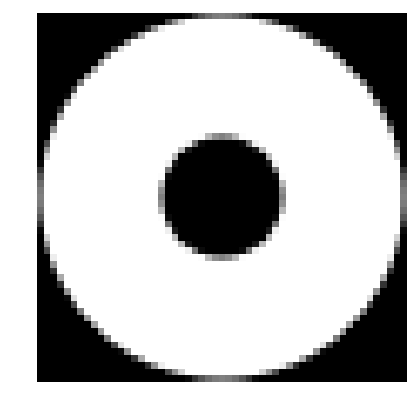

PyObject <matplotlib.image.AxesImage object at 0x7faf441cc610>

In [8]:
plt[:figure](); plt[:axis]("off"); plt[:imshow](mask_out, cmap="gray")

In [9]:
?makeInnerMask

search:



```
makeInnerMask(r_in[, AA=0.0])
```

Create a matrix filled with a ring of non-zero floats. The sum of matrix is normalized to be equal to 1.0.

# Arguments

  * `r_in::Int`: the inner radius of the ring. Must be smaller than r_out.
  * `AA::Float64`: Thickness of antialiasing. 0.0 means no antialiasing.
